In [1]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import requests
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [4]:
df_feat = pd.read_csv('file_feature.csv')

# 1)-Applying model and then predict

In [5]:
df_feat.shape

(1200, 30)

In [6]:
y=df_feat['Churn.Status']

In [7]:
df_model = df_feat.drop(['Churn.Status'], axis=1)

In [8]:
X = StandardScaler().fit_transform(df_model)
X.shape

(1200, 29)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1660, random_state=0)

In [10]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
pred_rf[:5]

array([1, 1, 0, 0, 0], dtype=int64)

# 2)- Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. 
Key matrix elements are:

- true positives (TP): These are cases in which we predicted yes (customers churned), and actually they do have churned i.e left.
- true negatives (TN): We predicted loyal customers,actually they were.
- false positives (FP): We predicted churned customers, but actually they were loyal ones. (Also known as a "Type I error.")
- false negatives (FN): We predicted non-churned customers, but they actually have left i.e churned. (Also known as a "Type II error.")

In [11]:
import itertools
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
cm = confusion_matrix(y_test, pred_rf)
cm

array([[92, 17],
       [18, 73]], dtype=int64)

In [13]:
#save confusion matrix and slice into four piece
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

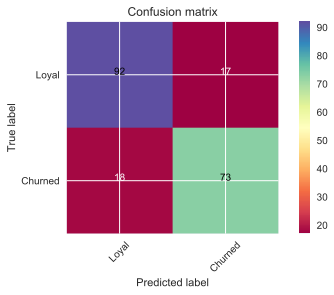

In [14]:
# False=0; True=1 ====> Loyal=0, Churned=1
plot_confusion_matrix(cm, classes=['Loyal', 'Churned'])

### Null accuracy

accuracy that could be achieved by always predicting the most frequent class

In [15]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    109
1     91
Name: Churn.Status, dtype: int64

In [16]:
# calculate the percentage of ones
y_test.mean()

0.455

In [17]:
# calculate the percentage of zeros
1 - y_test.mean()

0.5449999999999999

In [18]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.5449999999999999

So, a rough model will have accuracy of 54 

### Classification Accuracy

Overall, how often is the classifier correct?

In [19]:
print(accuracy_score(y_test, pred_rf))

0.825


In [20]:
print((TP + TN) / float(TP + TN + FP + FN))

0.825


Our result is incredible considering so low null accuracy. It shows how well feature engineering has worked for us

### Classification Error
    
Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [21]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, pred_rf))

0.175
0.17500000000000004


# 3)- Other matrices

### Sensitivity

When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances?
Also known as "True Positive Rate" or "Recall"

In [22]:
print(recall_score(y_test, pred_rf))

0.8021978021978022


In [23]:
print(TP / float(TP + FN))

0.8021978021978022


### Specificity

When the actual value is negative, how often is the prediction correct?

How "specific" (or "selective") is the classifier in predicting positive instances?

In [24]:
# No sklearn formula

print(TN / float(TN + FP))

0.8440366972477065


### False Positive Rate

When the actual value is negative, how often is the prediction incorrect?

In [25]:
print(FP / float(TN + FP))

0.1559633027522936


### Precision

When a positive value is predicted, how often is the prediction correct?

How "precise" is the classifier when predicting positive instances?

In [26]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, pred_rf))

0.8111111111111111
0.8111111111111111


**Precision, Specificity are high. On other hand, sensitivity is high too. That is strange. It means that we can predict both False Positive and Fale negative. It might be due to balanced classes**

### classification_report

In [27]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       109
           1       0.81      0.80      0.81        91

   micro avg       0.82      0.82      0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



# 4)-Adjusting the classification threshold

In [28]:
# print the first 10 predicted responses
rf.predict(X_test)[0:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

In [29]:
pred_rf[:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

### predict_proba

In [30]:
# print the first 10 predicted probabilities of class membership
rf.predict_proba(X_test)[0:10, :]

array([[0.3, 0.7],
       [0.3, 0.7],
       [0.6, 0.4],
       [0.7, 0.3],
       [0.6, 0.4],
       [0. , 1. ],
       [0.6, 0.4],
       [0.9, 0.1],
       [0. , 1. ],
       [0.3, 0.7]])

In [31]:
# print the first 10 predicted probabilities for class 1
rf.predict_proba(X_test)[0:10, 1]

array([0.7, 0.7, 0.4, 0.3, 0.4, 1. , 0.4, 0.1, 1. , 0.7])

In [32]:
pred_prob_cl_one = rf.predict_proba(X_test)[:, 1]
print(pred_prob_cl_one[:5])

[0.7 0.7 0.4 0.3 0.4]


Text(0,0.5,'Frequency')

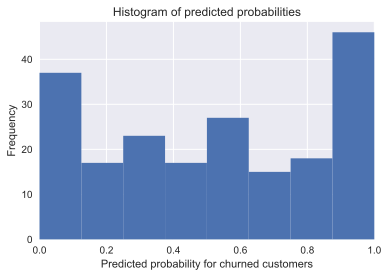

In [33]:
# histogram of predicted probabilities for churned customers
plt.hist(pred_prob_cl_one, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for churned customers')
plt.ylabel('Frequency')

### Increase the threshold 

for predicting loyalty pattern in order to improve the Specificity of the classifier.

False positive (loyal customers are predicted as churned incorrectly) matters more to us as we want to keep our loyal customers loyal. On other hand, False negative(churned customers are predicted incorrectly as loyal ones) is of less concern.

- We need a classifer that is more specific for loyal customer and less sensitive towards churned customers.

In [34]:
from sklearn.preprocessing import binarize
y_pred_class_spec = binarize([pred_prob_cl_one], 0.9)[0]

In [35]:
y_pred_class_spec[0:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

In [36]:
print(metrics.confusion_matrix(y_test, pred_rf))

[[92 17]
 [18 73]]


In [37]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class_spec))

[[107   2]
 [ 69  22]]


In [38]:
# check value of specificity(remains same 0.84)
print(TN / float(TN + FP))

0.8440366972477065


**Value remains same. But, we can see confusion matrix is better. Now we have only 2 False positive values left i.e Only two miscalculation of loyal customers as churned ones**

In [39]:
# sensitivity has decreased (used to be 0.80)
print(recall_score(y_test, y_pred_class_spec))

0.24175824175824176


In [49]:
# Precison jumps from 81 to 91
print(metrics.precision_score(y_test, y_pred_class_spec))

0.9166666666666666


### ROC curve

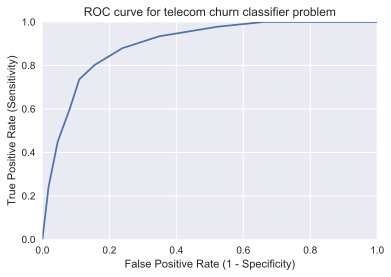

In [40]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob_cl_one)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for telecom churn classifier problem')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context

You can't actually see the thresholds used to generate the curve on the ROC curve itself

In [41]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [42]:
evaluate_threshold(0.5)

Sensitivity: 0.8021978021978022
Specificity: 0.8440366972477065


In [43]:
evaluate_threshold(0.9)

Sensitivity: 0.24175824175824176
Specificity: 0.981651376146789


In [47]:
print(classification_report(y_test, y_pred_class_spec))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       109
           1       0.92      0.24      0.38        91

   micro avg       0.65      0.65      0.65       200
   macro avg       0.76      0.61      0.57       200
weighted avg       0.75      0.65      0.58       200



**Hence, our classifer is more specific for loyal customer and less sensitive towards churned customers.**

### AUC

AUC is the percentage of the ROC plot that is underneath the curve:

In [44]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, pred_prob_cl_one))

0.8962597035991532


In [45]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8962597035991532

- AUC is useful as a single number summary of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation.
- Greater value close to 1 is better. If lower value i.e 0.5 then it is random guessing. In our case, it is good value


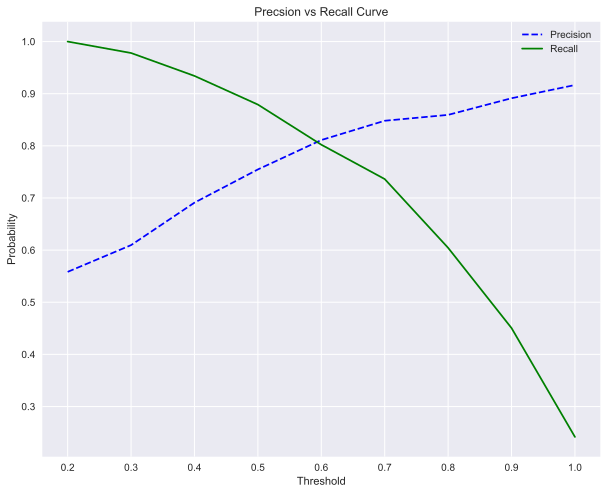

In [48]:
from sklearn.metrics import roc_curve, precision_recall_curve
prec, rec, thres = precision_recall_curve(y_test, pred_prob_cl_one)

def _plot_prec_rec_curve(prec, rec, thres):
    plot_pr = plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()
    #return plot_pr(it creates duplicate graph)

_plot_prec_rec_curve(prec, rec, thres)